# Homework 10

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Sunday, November 18th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# pymc3 and theano imports

import pymc3 as pm
from pymc3 import Normal, Binomial, sample, Model 
from pymc3.math import invlogit
import theano.tensor as T
from theano import shared

/Users/gwungwun/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Question 1: Metropoflix and Chill (What's your Net Worth)?

**coding required**

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you may not recall the correct order, but the mistakes you make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *The Godfather: Part II*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *The Godfather: Part II*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Unfortunately, your answer is wrong.  Fortunately (for our purposes) we have a way of quantifying just how wrong. Define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is an indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}$$
where $\lambda$ can be thought of as an inverse temperature

1.1. Implement a Metropolis sampler to produce sample guesses from 500 individuals, with the $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

1.2. Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various $\lambda$ values. 

1.3. How does $\lambda$ affect the probability that *The Shawshank Redemption* is ranked as the top movie?


**Gratuitous Titular Reference**:  

It's 2018 -- Even Wikipedia knows what [Netflix and Chill](https://en.wikipedia.org/wiki/Netflix_and_chill) is about. (mixtape by Grime MC Merky ACE].  

[Drake's the type of dude](https://knowyourmeme.com/memes/drake-the-type-of) to not care about [netflix and chill but about that net net net worth](https://youtu.be/DRS_PpOrUZ4?t=224) 

Drake may wanna know if [Kiki/KB](https://www.thefader.com/2018/10/24/real-kiki-drake-in-my-feelings-interview-kyanna-barber) is feeling him, but the [NTSB](https://www.ntsb.gov)  [definitely isn't](https://www.cnn.com/2018/07/25/entertainment/ntsb-in-my-feelings/index.html)

Shout out [Nawlins](https://riverbeats.life/neworleans/drake-shares-his-in-my-feelings) and [Atlanta](http://www.thefader.com/2018/06/29/drake-sampled-atlanta-scorpion).

In [12]:
## 1.1
lambda_ls = [0.2, 0.5, 1]
w = np.array([1,2,3,4,5])

In [19]:
def metropolis(p, qdraw, nsamp, xinit, l, w = w):
    samples=np.empty([nsamp,5])
    x_prev = xinit
    accepted = 0
    
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star, l)
        p_prev = p(x_prev, l)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i,:] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i,:]= x_prev
            
    return samples, accepted*1./nsamp

def prop(x):
    return np.random.permutation(x)

def f(x, l):
    return np.exp(-l * d(x))

def d(theta, w = w):
    return np.sum(theta != w)

In [41]:
x0=np.random.choice(w, 5, replace= False)
N = 500
samps_ls = []

for l in lambda_ls:
    samps,accept_rate = metropolis(f, prop, N, x0, l)
    samps_ls.append(samps)
    print("acceptance rate = {} for lambda = {}".format(accept_rate, l))

acceptance rate = 0.874 for lambda = 0.2
acceptance rate = 0.722 for lambda = 0.5
acceptance rate = 0.414 for lambda = 1


In [42]:
for idx, l in enumerate(lambda_ls):
    samps= samps_ls[idx]
    rank, count = np.unique([np.str(s) for s in samps], return_counts= True)
    print("top 5 choices :{} with counts {},  for lambda = {}".format([r for r in rank[:5]],  [c for c in count[:5]], l))

top 5 choices :['[1. 2. 3. 4. 5.]', '[1. 2. 3. 5. 4.]', '[1. 2. 4. 3. 5.]', '[1. 2. 4. 5. 3.]', '[1. 2. 5. 3. 4.]'] with counts [14, 4, 4, 2, 4],  for lambda = 0.2
top 5 choices :['[1. 2. 3. 4. 5.]', '[1. 2. 3. 5. 4.]', '[1. 2. 4. 3. 5.]', '[1. 2. 4. 5. 3.]', '[1. 2. 5. 3. 4.]'] with counts [28, 29, 8, 4, 2],  for lambda = 0.5
top 5 choices :['[1. 2. 3. 4. 5.]', '[1. 2. 3. 5. 4.]', '[1. 2. 4. 3. 5.]', '[1. 2. 4. 5. 3.]', '[1. 2. 5. 3. 4.]'] with counts [126, 1, 15, 6, 16],  for lambda = 1


In [43]:
## 1.2
for idx, l in enumerate(lambda_ls):
    samps= samps_ls[idx]
    prob = np.mean([s[0] == 1 for s in samps])
    print("probability that The Shawshank Redemption is ranked as the top movie (ranked number 1){},  for lambda = {}".format(prob, l))

probability that The Shawshank Redemption is ranked as the top movie (ranked number 1)0.25,  for lambda = 0.2
probability that The Shawshank Redemption is ranked as the top movie (ranked number 1)0.38,  for lambda = 0.5
probability that The Shawshank Redemption is ranked as the top movie (ranked number 1)0.456,  for lambda = 1


<div class="answer-separator">
------------------------
</div>

## Question 2: In a Flash the Iris devient un Fleur-de-Lis.

**coding required**

We've done classification before, but the goal of this problem is to introduce you to the idea of classification using Bayesian inference. 

Consider the famous *Fisher flower Iris data set* a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe90cwt3dla%2Firis.csv).

Let $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is the standard feature vector corresponding to an offset 1 and the four components explained above. $Y \in \{0,1\}$ are the scalar labels of a class. In other words the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features -- petal length, petal width, sepal length and sepal width -- along with the offset make up your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Note: You might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).


2.1. Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

2.2. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.

2.3. Find the MAP for the posterior on the training set.

2.4. Implement a PyMC3 model to sample from this posterior of $\beta$.  

2.5. Generate 5000 samples of $\beta$.  Visualize the betas and generate a traceplot and autocorrelation plots for each beta component.

2.6. Based on your samples construct an estimate for the posterior mean.

2.7. Select at least 2 datapoints and visualize a histogram of the posterior probabilities.  Denote the posterior mean and MAP on your plot for each datapoint


Although having the posterior probabilities is nice, they are not enough.  We need to think about how to make predictions based on our machinery.  If we define the following:

 - $p_{MEAN}$: using the posterior mean betas to generate probabilities for each data point
 - $p_{MAP}$: using the posterior MAP betas to generate probabilities for each data point
 - $p_{CDF}$: using the fraction of your posterior samples have values above 0.5 for each data point
 - $p_{PP}$:  using the fraction of 1s out of the samples drawn from the posterior predictive distribution for each data point

2.8. Plot the distributions of $p_{MEAN}$, $p_{CDF}$, $p_{MAP}$ and $p_{PP}$ over all the data points in the training set. How are these different?


How do we turn these probabilities into predictions?  *There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

- Sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

- Do the intuitive "machine-learning-decision-theoretic" (MLDT) thing and you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

2.9. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

2.10. For every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Using the MLDT defined above, overlay a plot of the histogram of the misclassification rate for the posterior on the corresponding plot for the posterior-predictive you constructed in 2.9.  Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 

2.11. Repeat 2.9 and 2.10 for the test set (i.e. make predictions).  Describe and interpret the widths of the resulting distributions.

**Gratuitous Titular References**:  

[The Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) was introduced by Ronald Fisher as part of a [famous article](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1469-1809.1936.tb02137.x) introducing [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

The three iris variants in the dataset were at the time [difficult to tell apart morphologically](https://www.jstor.org/stable/2394164?seq=1#page_scan_tab_contents)

While the origin of the [Fleur-de-Lis is debated](https://www.heraldica.org/topics/fdl.htm), it is most likely an [Iris florentina](https://en.wikipedia.org/wiki/Iris_florentina) or [Iris pseudacorus](https://en.wikipedia.org/wiki/Iris_pseudacorus) but not a [lily flower](https://www.collinsdictionary.com/dictionary/english-french/lily).

[Iris West](https://en.wikipedia.org/wiki/Iris_West) is a love interest of [Barry Allen](https://en.wikipedia.org/wiki/Flash_(Barry_Allen) one of the main incarnations of [The Flash](https://en.wikipedia.org/wiki/Flash_(comics).  Coming from [Central City](https://en.wikipedia.org/wiki/Central_City_(DC_Comics) she is most likely classified as **not-virginica**.

In [3]:
# 2.1
df = pd.read_csv("iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df['virginica'] = df['class'].apply(lambda x: 1 if x == ' Iris-virginica' else 0)
df = df.drop(['class'], axis = 1)
df['ones'] = 1
df.head()

,sepal_length,sepal_width,petal_length,petal_width,virginica,ones
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


In [5]:
df_train, df_test = train_test_split(df, stratify = df.virginica, test_size = 0.4, random_state = 100)

In [6]:
x_train, y_train = df_train.drop(['virginica'], axis = 1).values, df_train.virginica.values
x_test, y_test = df_test.drop(['virginica'], axis = 1).values, df_test.virginica.values

In [7]:
x_shared = shared(x_train)
# y_shared = shared(y_train)
D = 5

In [10]:
## 2.2
with Model() as logistic_model:

    # Logit-linear model parameters
    beta = pm.Normal('beta', 0, sd=10, shape = D)

    # Calculate probabilities of death
    theta = pm.Deterministic('theta', invlogit(T.dot(x_shared, beta)))

    # Data likelihood
    obs_virginica = pm.Bernoulli('obs_virginica', p=theta, observed=y_train)

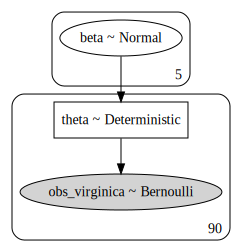

In [11]:
pm.model_to_graphviz(logistic_model)

In [12]:
# 2.3
map_params = pm.find_MAP(model=logistic_model)
map_params['beta']

logp = -24.004, ||grad|| = 0.19822: 100%|██████████| 40/40 [00:00<00:00, 4082.84it/s]


array([ -2.59690798,  -3.84718621,   5.41561429,   7.82401923,
       -12.67971932])

In [13]:
# 2.4
with logistic_model:
    trace = pm.sample(5000, start=map_params)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
Sampling 2 chains: 100%|██████████| 11000/11000 [01:16<00:00, 70.12draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


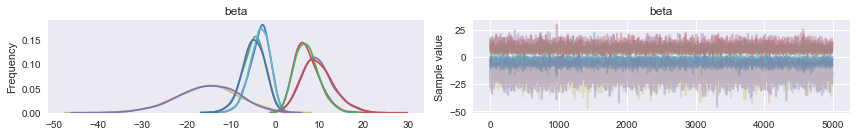

In [14]:
# 2.5
pm.traceplot(trace, varnames=['beta']);

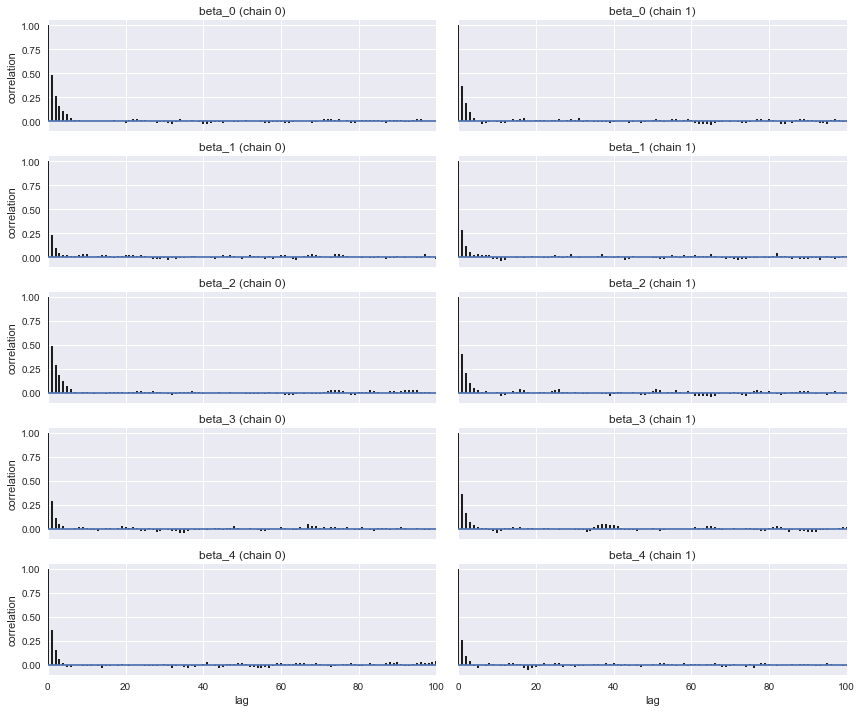

In [15]:
pm.autocorrplot(trace, varnames=['beta']);
plt.tight_layout()

In [28]:
# 2.6
beta_mean = trace['beta'].mean(axis=0)
beta_mean

array([ -3.53190144,  -4.89918652,   7.15804211,   9.62299052,
       -15.41395277])

In [37]:
# 2.7
df_train.head(3)

,sepal_length,sepal_width,petal_length,petal_width,virginica,ones
111,6.4,2.7,5.3,1.9,1,1
46,5.1,3.8,1.6,0.2,0,1
90,5.5,2.6,4.4,1.2,0,1


In [61]:
beta = trace['beta']

def y_post(x, beta = beta):
    p = np.dot(beta, x.T)

    return 1./(1 + np.exp(-p))

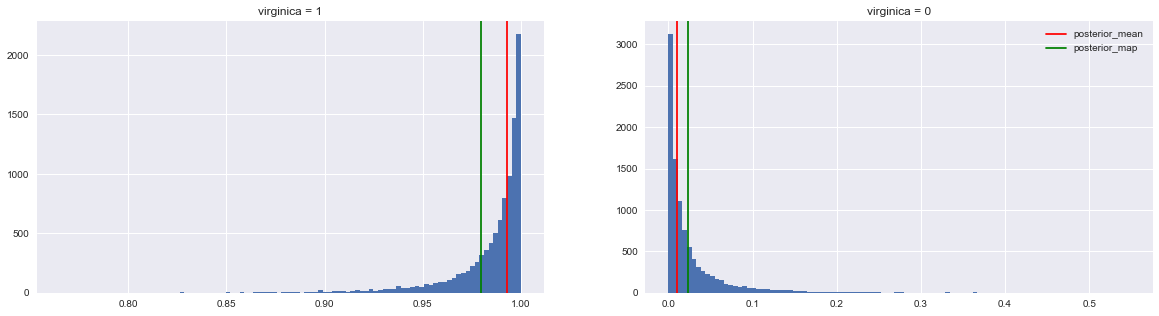

In [62]:
idx_ls = [0, 2]
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for idx, i in enumerate(idx_ls):
    x = x_train[i]
    y = y_train[i]
    y_p = y_post(x, beta)
    ax[idx].hist(y_p, bins = 100)
    ax[idx].axvline(y_post(x, beta=beta_mean), color = 'red', label = 'posterior_mean')
    ax[idx].axvline(y_post(x, beta=map_params['beta']), color = 'green', label = 'posterior_map')
    ax[idx].set_title("virginica = {}".format(y))
plt.legend();


In [102]:
# 2.8
p_mean = y_post(x_train, beta_mean)
p_map = y_post(x_train, map_params['beta'])

p_posterior = y_post(x_train, beta)
p_cdf = np.mean([p_posterior > 0.5], axis = 1)[0]

In [78]:
posterior_pred = pm.sample_ppc(trace, model=logistic_model, samples=10000)

100%|██████████| 10000/10000 [00:05<00:00, 1772.56it/s]


In [97]:
p_pp = np.mean(posterior_pred['obs_virginica'], axis = 0)

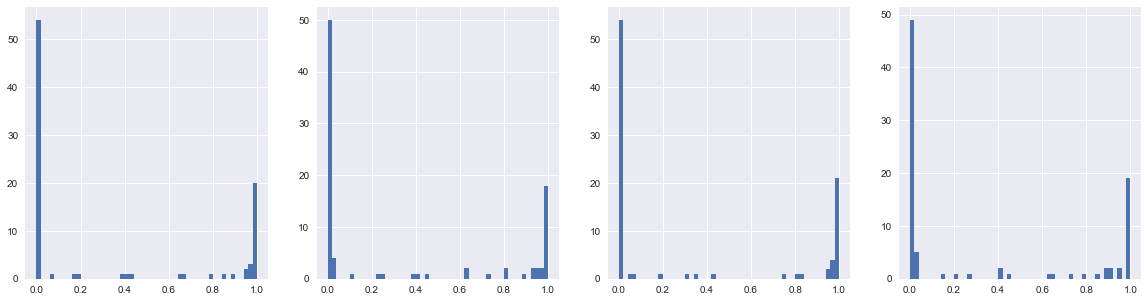

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx,p in enumerate([p_mean, p_map, p_cdf, p_pp]):
    ax[idx].hist(p, bins = 50)

In [126]:
# 2.9 & 2.10
mldt = np.mean(np.abs(y_train - p_posterior > 0.5), axis = 0)

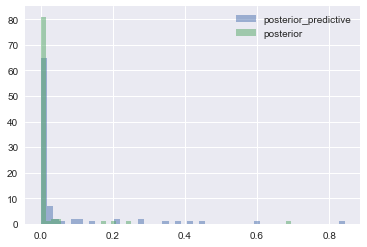

In [128]:
ppc_misclass = np.mean(np.abs(y_train - posterior_pred['obs_virginica']), axis = 0)
plt.hist(ppc_misclass, bins = 50, alpha = 0.5, label= 'posterior_predictive');
plt.hist(mldt, bins = 50, alpha = 0.5, label = 'posterior');
plt.legend();

In [131]:
# 2.11
p_posterior_test = y_post(x_test, beta)
ppc_misclass = np.mean(np.abs(y_test - np.random.binomial(1, p_posterior_test)), axis = 0)

In [132]:
mldt = np.mean(np.abs(y_test - np.random.binomial(1, p_posterior_test) > 0.5), axis = 0)

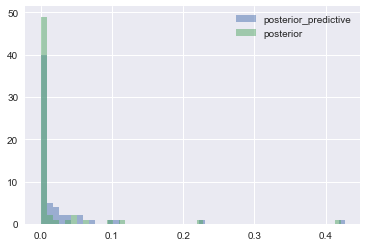

In [133]:
plt.hist(ppc_misclass, bins = 50, alpha = 0.5, label= 'posterior_predictive');
plt.hist(mldt, bins = 50, alpha = 0.5, label = 'posterior');
plt.legend();

<div class="answer-separator">
------------------------
</div>

## Question 3 - Our Yelp Restaurant Review is in and the Fish is So Raw!

**no coding required**

In this course, we've spent a lot of time learning algorithms for performing inference on complex models. We've also spent time using these models to make decisions regarding our data. But in nearly every assignment, the model for the data is specified in the problem statement. In real life, the creative and, arguably, much more difficult task is to start with a broadly defined goal and then to customize or create a model which will meet this goal in some way. 


This homework problem is atypical in that it does not involve any programming or (necessarily) difficult mathematics/statistics. The process of answering these questions *seriously* will however give you an idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model if and when you're called upon to do so.

***Grading:*** *We want you to make a genuine effort to mold an ambiguous and broad real-life question into a concrete data science or machine learning problem without the pressure of getting the "right answer". As such, we will grade your answer to this homework question on a pass/fail basis. Any reasonable answer that demonstrates actual effort will be given a full grade.*

We've compiled for you a fairly representative selection of [Yelp reviews](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe92vh7ni6e%2Fyelp_reviews.zip for a (now closed) sushi restaurant called Ino's Sushi in San Francisco. Read the reviews and form an opinion regarding the various qualities of Ino's Sushi. Answer the following:

3.1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

3.2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 
  
3.3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

3.4. Identify all the ways in which the task in 3.2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

3.5. Now let us think of a different problem, a regression problem in which our aim is to predict and do inference on what rating a given user of Yelp might give a particular restaurant. How might you estimate the across-user quality of a restaurant from data? And how might you estimate the across-restaurant curmudgeonlyness of a user?

3.6 Additionally, consider a "space of latent factors" where aspects of the user's taste interact with aspects of the restaurant. An example of such a factor might be the user's propensity to get emotional after having the perfect filet-mignon. How might you combine this information with that in 3.5 to improve your prediction and inference?

3.1 different perspectives: food service

3.3 mix of positive and negative comments

3.4 for every sentence, LDA find topic, NLP find sentiment, 
    then weighted average every topic

3.5 recommendation system -- alternative least square

3.6 content based ...

**Gratuitous Titular Reference**:  

[Sushi is not raw fish](http://www.todayifoundout.com/index.php/2011/12/sushi-is-not-raw-fish)

![](https://i.imgflip.com/pnawi.jpg)

[More Gordon Ramsey memes](https://knowyourmeme.com/memes/people/gordon-ramsay)

<div class="answer-separator">
------------------------
</div>